## K-Means Clustering

In [1]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
#import mpld3

In [2]:
full_df = pd.read_csv('linguistic_features/en_vaccine_sentiment_df')
full_df.head()

,Comment,Tags,old_Comment
0,i want to see how_many of the current covid ca...,Data and tracking vaccines,i want to see how many of the current covid ca...
1,i wanted to know the number of deaths,Data and tracking vaccines,i wanted to know the number of deaths
2,are you_hiding the deaths_from vaccination ?,Data and tracking vaccines,are you hiding the deaths from vaccination ?
3,how come there are so few reported deaths in t...,Data and tracking vaccines,how come there are so few reported deaths in t...
4,each_province should state total vaccinations ...,Data and tracking vaccines,each province should state total vaccinations ...


In [3]:
len(full_df)

17858

In [4]:
stopwords = nltk.corpus.stopwords.words('english')

In [5]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [31]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [32]:
comments = full_df.old_Comment.to_list()
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in comments:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [33]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(2,4))

%time 

tfidf_matrix = tfidf_vectorizer.fit_transform(full_df.old_Comment)

print(tfidf_matrix.shape)

Wall time: 0 ns


C:\Users\Jan\miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(17858, 202683)


In [35]:
terms = tfidf_vectorizer.get_feature_names()

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [104]:
#kmeanses = []
#for k in range(1,10):
#    kmeanses.append(KMeans(n_clusters = k).fit(tfidf_matrix))

In [105]:
'''
import matplotlib.pyplot as plt
w=10
h=11
def plot_elbow(kmeanses):
    plt.figure(figsize = (w,h))
    plt.axvline(x=5, linestyle='-.', c="black")
    plt.plot(range(1,10),[k.inertia_ for k in kmeanses], '-o');
    ax = plt.gca()
    ax.tick_params('both', labelsize=(w+h)/2)
    ax.set_xlabel('K', fontsize=w)
    ax.set_ylabel("Inertia", fontsize=w)

plot_elbow(kmeanses)
'''

'\nimport matplotlib.pyplot as plt\nw=10\nh=11\ndef plot_elbow(kmeanses):\n    plt.figure(figsize = (w,h))\n    plt.axvline(x=5, linestyle=\'-.\', c="black")\n    plt.plot(range(1,10),[k.inertia_ for k in kmeanses], \'-o\');\n    ax = plt.gca()\n    ax.tick_params(\'both\', labelsize=(w+h)/2)\n    ax.set_xlabel(\'K\', fontsize=w)\n    ax.set_ylabel("Inertia", fontsize=w)\n\nplot_elbow(kmeanses)\n'

In [37]:
from sklearn.cluster import KMeans

num_clusters = 10

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 53 s


In [38]:
vaccine_df = {'comment': comments, 'cluster': clusters}

clustered_df = pd.DataFrame(vaccine_df, index = [clusters] , columns = ['comment', 'cluster'])

In [161]:
full_df['Tags'].value_counts()

Getting vaccinated - When / Where / What                                  4452
Getting vaccinated - Registration / notifications                         3737
Vaccine safety (health issues / ingredients / side effects / research)    2921
Data and tracking vaccines                                                2779
Vaccine effectiveness / delayed dosage                                    2136
Vaccine strategy: Authorization / Eligibility / Priorities                 928
Vaccines - Other                                                           799
Life after vaccination                                                     106
Name: Tags, dtype: int64

In [39]:
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    words = set()
    for ind in order_centroids[i, :10]:
        #print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        #words.add(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])
        words.add(terms[ind])
    print(words)
    print()

Top terms per cluster:

Cluster 0 words:{'book vaccin', 'year old', 'second shot', 'year old vaccin', 'age vaccin', 'appoint vaccin', 'sign vaccin', 'inform date', 'old vaccin', 'make appoint'}

Cluster 1 words:{'regist vaccin', 'year old', 'moderna vaccin', 'vaccin covid', 'second shot', 'want know', 'receiv vaccin', 'know vaccin', 'second vaccin', 'second dose'}

Cluster 2 words:{'use canada', 'differ vaccin use', 'type vaccin', 'type vaccin use', 'know vaccin use', 'vaccin use clinic', 'vaccin use site', 'use clinic', 'vaccin use canada', 'vaccin use'}

Cluster 3 words:{'book appoint vaccin', 'tri book appoint', 'book appoint', 'want book appoint', 'appoint vaccin', 'appoint covid', 'book appoint covid', 'book appoint covid vaccin', 'want book', 'appoint covid vaccin'}

Cluster 4 words:{'vaccin age', 'look age group', 'vaccin age group', 'age group elig', 'age group', 'group elig', 'know age', 'group vaccin', 'know age group', 'age group vaccin'}

Cluster 5 words:{'dose astrazeneca 

In [40]:
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    words = set()
    for ind in order_centroids[i, :6]:
        #print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        words.add(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])
    print(words)
    print()

Top terms per cluster:

Cluster 0 words:{'bookings', 'sign', 'information', 'old', 'years', 'make'}

Cluster 1 words:{'receiving', 'second', 'want', 'register', 'years'}

Cluster 2 words:{'types', 'vaccine', 'different', 'know', 'used'}

Cluster 3 words:{'appointment', 'bookings', 'want'}

Cluster 4 words:{'age', 'vaccine', 'group'}

Cluster 5 words:{'dose', 'receiving', 'astrazeneca', 'blood', 'information'}

Cluster 6 words:{'effects', 'dose', 'second', 'pfizer'}

Cluster 7 words:{'register', 'covid', 'bookings', 'appointment'}

Cluster 8 words:{'johnson', 'information'}

Cluster 9 words:{'register', 'need', 'vaccine', 'want'}



### Within Specific Tags

In [17]:
vaccine_other = full_df[full_df['Tags']=='Getting vaccinated - When / Where / What']

In [18]:
vaccine_other.head()

,Comment,Tags,old_Comment
6516,i got my shot at a pharmacy and they didn_t ha...,Getting vaccinated - When / Where / What,i got my shot at a pharmacy and they didn t ha...
6517,can t_find any info for second_shot availabili...,Getting vaccinated - When / Where / What,can t find any info for second shot availabili...
6518,when will the vaccines for bonavista be ready ...,Getting vaccinated - When / Where / What,when will the vaccines for bonavista be ready ...
6519,can i drink_alcohol after i get my vaccine shot,Getting vaccinated - When / Where / What,can i drink alcohol after i get my vaccine shot
6520,can i get vaccinated in a different town from ...,Getting vaccinated - When / Where / What,can i get vaccinated in a different town from ...


In [19]:
comments = vaccine_other.old_Comment.to_list()
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in comments:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [20]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english',
                                 use_idf=True, tokenizer=tokenize_only, ngram_range=(1,3))

%time 

tfidf_matrix = tfidf_vectorizer.fit_transform(vaccine_other.old_Comment)

print(tfidf_matrix.shape)

Wall time: 0 ns
(4452, 36012)


In [27]:
terms = tfidf_vectorizer.get_feature_names()

from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

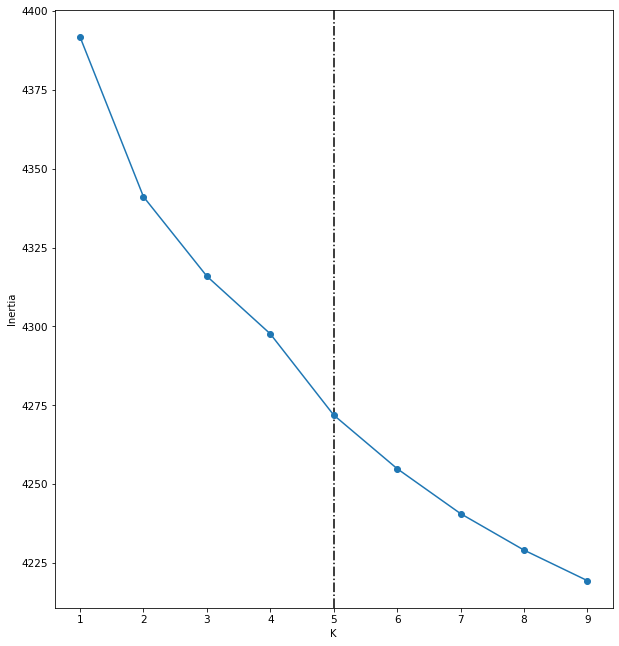

In [28]:
from sklearn.cluster import KMeans

kmeanses = []
for k in range(1,10):
    kmeanses.append(KMeans(n_clusters = k).fit(tfidf_matrix))
    
import matplotlib.pyplot as plt
w=10
h=11
def plot_elbow(kmeanses):
    plt.figure(figsize = (w,h))
    plt.axvline(x=5, linestyle='-.', c="black")
    plt.plot(range(1,10),[k.inertia_ for k in kmeanses], '-o');
    ax = plt.gca()
    ax.tick_params('both', labelsize=(w+h)/2)
    ax.set_xlabel('K', fontsize=w)
    ax.set_ylabel("Inertia", fontsize=w)

plot_elbow(kmeanses)

In [29]:
#from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 9.59 s


In [30]:
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    words = set()
    for ind in order_centroids[i, :10]:
        #print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        #words.add(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])
        words.add(terms[ind])
    print(words)
    print()

Top terms per cluster:

Cluster 0 words:{'dose', 'second', 'pfizer', 'age', 'vaccine', 'vaccination', 'old', 'covid vaccine', 'covid', 'vaccinated'}

Cluster 1 words:{'second', 'pfizer', 'second shot', '2nd shot', 'vaccine', 'covid shot', 'shot', 'vaccine shot', 'shot second', 'second vaccine'}

Cluster 2 words:{'year old vaccinated', 'old vaccinated', 'years old vaccinated', 'years old', 'looking vaccinated', 'people vaccinated', 'age vaccinated', 'old', 'years', 'vaccinated'}

Cluster 3 words:{'know vaccine', 'want', 'want know vaccinated', 'want know', 'want know vaccine', 'vaccine', 'want know age', 'eligible', 'know', 'vaccinated'}

Cluster 4 words:{'groups say grouos', 'vaccine', 'groups seniors plus', 'groups start', 'groups say', 'groups seniors', 'zyork region people', 'groups scheduling', 'groups started', 'groups scheduling vaccines'}

